# Colaborative Filtering

Collaborative filtering is a way recommendation systems filter information by using the preferences of other people. It uses the assumption that if person A has similar preferences to person B on items they have both reviewed, then person A is likely to have a similar preference to person B on an item only person B has reviewed.

Collaborative filtering is used by many recommendation systems in various fields, including music, shopping, financial data, and social networks and by various services (YouTube, Reddit, Last.fm). Any service that uses a recommendation system most likely employs collaborative filtering.

source: https://brilliant.org/wiki/collaborative-filtering/

## Memory-based CF

Memory-Based Collaborative Filtering approaches can be divided into two main sections: user-item (user-based) filtering and item-item (item-based) filtering. A user-item filtering takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

Item-Item Collaborative Filtering: “Users who liked this item also liked …”

User-Item Collaborative Filtering: “Users who are similar to you also liked …”

source: https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c

## Model-based CF

Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

source: https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c

## Task

In this exercise, you shall work with various collaborative filtering approaches. Specifically, you shall compare

* User based filtering
* Item based filtering
* One other model based filtering approach

You can reuse existing libraries and code examples (if you do so, please properly quote the origin, otherwise it has to be considered plagiarism), and you shall compare their performance in two ways

* Effectiveness of the recommendation on a supplied training set.
* Efficiency of the recommendation (i.e. runtime).

The dataset to be used is the MovieLens dataset. You shall first work with the smallest version available, with 100k ratings, at https://grouplens.org/datasets/movielens/100k/

To ensure that we can compare the results across all your peers in the course, you shall proceed as follows

* Split the dataset into 80:20 training:test set, after shuffling the data. 
* For evaluation of effectiveness, we will utilise MSE.

Your solution shall include the code, and a report on your findings - which methods worked well in regards to effectiveness and efficiency? Are the result in general usable?

After the first step on the 100k database, obtain the next bigger version (1M), and just test your algorithms for effectiveness - do the methods scale to the increased size?

## Dataset description

For this exercise 2 movielense datasets were used: 100k (https://grouplens.org/datasets/movielens/100k/) and 1M (https://grouplens.org/datasets/movielens/1M/)

MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

The 100k data set consists of:
* 100,000 ratings (1-5) 
* from 943 users 
* on 1682 movies.

The 1m data set consists of:
* 1,000,209 ratings (1-5) 
* from 6,040 users 
* on 3,952 movies.  

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set.

sources: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt http://files.grouplens.org/datasets/movielens/ml-1m-README.txt


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hashlib import md5
from zipfile import ZipFile
import urllib.request
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error
from math import sqrt

data_attributes=["user_id","item_id","rating","timestamp"]

# 100k Dataset

## Data aquicition and preperation

First the dataset is downloaded as zip-archive. To save bandwidth ,time and space it is cached but not decompressed. Only the relevant data file inside the archive is read and stored in a DataFrame.

In [2]:
def get_content_file(url):
    h = md5(url.encode()).hexdigest()
    path = ".tmp/" + h
    file_path = path + "/data.zip"
    if not os.path.exists(file_path):
        if not os.path.exists(path):
            os.makedirs(path)
        urllib.request.urlretrieve(url, file_path)
    return file_path


file_path = get_content_file("http://files.grouplens.org/datasets/movielens/ml-100k.zip")
with ZipFile(file_path).open("ml-100k/u.data") as decompressed_file:
    df_100k = pd.read_csv(
        decompressed_file,
        names=data_attributes,
        sep="\t"
    )

To make evaluating the predictions possible, the dataset is split in a 80:20 ratio and converted to a "user x item = rating" pivot table. As shown below, the distribution of the test and train set is almost identical. It can be assumed that both sets are representitve for the whole set.

Train Data Historgram
Test Data Historgram


Text(0.5, 1.0, 'Test set distribution')

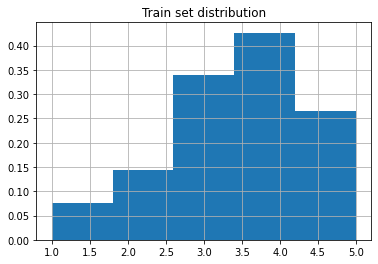

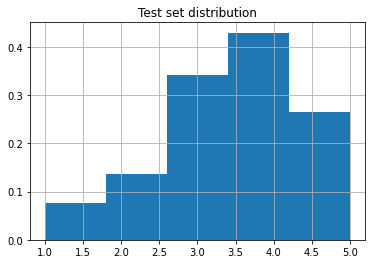

In [21]:
def split_and_pivot_dataset(df, test_size):
    train_data, test_data = train_test_split(df, test_size=test_size)

    # create user-item matrix as pivot table
    train_data_pivot = train_data.pivot_table(index='user_id', columns='item_id', values='rating')\
        .reindex(sorted(df.user_id.unique()), axis=0)\
        .reindex(sorted(df.item_id.unique()), axis=1)

    # create testset
    test_data_pivot = test_data.pivot_table(index='user_id', columns='item_id', values='rating')\
        .reindex(sorted(df.user_id.unique()), axis=0)\
        .reindex(sorted(df.item_id.unique()), axis=1)
    
    return (train_data_pivot, test_data_pivot)


train_data_pivot_100k, test_data_pivot_100k = split_and_pivot_dataset(df_100k, 0.2)

pd.DataFrame(train_data_pivot_100k.values.flatten()).hist(bins=5, range=(1,5), density=True)
plt.title('Train set distribution')
pd.DataFrame(test_data_pivot_100k.values.flatten()).hist(bins=5, range=(1,5), density=True)
plt.title('Test set distribution')

## User-based prediction

To predict items of interrest using an user-based approach a pairwise-distance matrix for all users (user x user) is computed. Using a cosine metric showed good results. To circumvent differences in the rating-behavior of different users the ratings have to be normalized using each users mean rating as the 0 value. By appling the score formular for user-based CF a prediction matrix is calculated. This matrix shows the predicted ratings for all items and users.  


Text(0.5, 1.0, 'User-based prediction distribution')

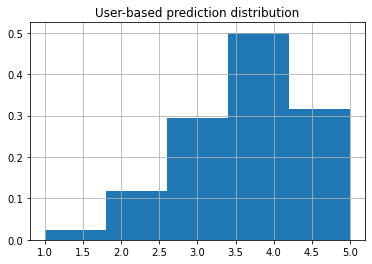

In [20]:
def predict_user(ratings):
    # calculate pairwise distances for users is calculated with cosine metric
    similarity = pairwise_distances(ratings.fillna(0), metric="cosine")
    # calculate mean values 
    mean_user_rating = ratings.mean(axis=1)
    # normalize ratings
    norm_ratings = (ratings.fillna(0) - mean_user_rating[:, np.newaxis])
    # calculate user-item correlations
    prediction = mean_user_rating[:, np.newaxis] + similarity.dot(norm_ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    return prediction + mean_user_rating[:, np.newaxis]
filled_ratings = train_data_pivot_100k.fillna(train_data_pivot_100k.mean())
user_prediction_100k = predict_user(train_data_pivot_100k)

pd.DataFrame(user_prediction_100k.flatten()).hist(bins=5, range=(1,5), density=True)
plt.title('User-based prediction distribution')

As shown above the distribution of the prediction is as expected.  

## Item-based prediction

Predicting items on a item-based approach followes the same principle, but uses a item-item similarity matrix. To preserve compareability the same metic (cosine) as before is used. Also it is not necessary to remove the rating bias because the user itself is used for prediction.

Text(0.5, 1.0, 'User-based prediction distribution')

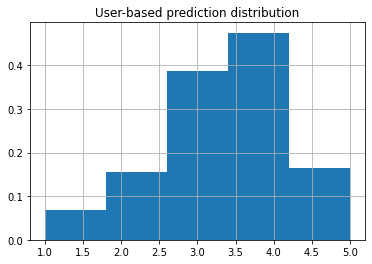

In [24]:
def predict_item(ratings):
    # calculate pairwise distances for users to items with cosine metric
    similarity = 1 - pairwise_distances(ratings.fillna(0).transpose(), metric="cosine")
    # calculate user-item correlations
    prediction = ratings.fillna(0).values.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return prediction + ratings.mean(axis=0)[np.newaxis, :]

item_prediction_100k = predict_item(train_data_pivot_100k)

pd.DataFrame(pd.DataFrame(item_prediction_100k).values.flatten()).hist(bins=5, range=(1,5), density=True)
plt.title('User-based prediction distribution')

Also this distribution of values matches the expectations.

## Model-based prediction

To show a model-based approach, a Singular value decomposition (SVD) of the given dataset is computed. SVD applies matrix factorization (A = U S V^T) to find 3 different matrices U, S and V. The U matrix represents the feature vectors corresponding to the users in the hidden feature space and the V matrix represents the feature vectors corresponding to the items in the hidden feature space. These can be used to make predictions on unknown values.

Text(0.5, 1.0, 'User-based prediction distribution')

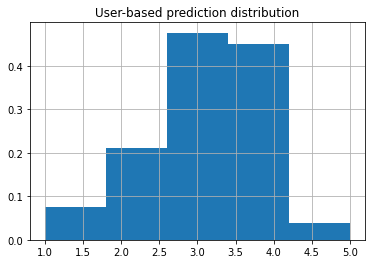

In [17]:
def predict_model(ratings):
    user_ratings_mean = ratings.mean(axis=0)
    unbiased_ratings = (ratings.fillna(user_ratings_mean) - user_ratings_mean[np.newaxis, :])
    R = unbiased_ratings.values.astype(float)
    U, S, Vt = svds(R, k=20)
    Sd = np.diag(S)
    return np.dot(np.dot(U, Sd), Vt) + user_ratings_mean[np.newaxis, :]

model_prediction_100k = predict_model(train_data_pivot_100k)

pd.DataFrame(pd.DataFrame(model_prediction_100k).values.flatten()).hist(bins=5, range=(1,5), density=True)
plt.title('User-based prediction distribution')

Even if some bins are obviously overrepresented (3.0), the others look quite promesing.

## Results

To get a clear and reliable measurment on how good the 3 given methods perform, two metrics are calculated: Effectiveness (MSE) and Efficiency (runtime).

### Efficiency

As shown below, all 3 methods where measured using the builtin `%timeit` command. This takes each routine and executes it n times to calculate mean runtime and standard deviation. 

* The **user-bases** approach is the fasttest with 160 ms ± 12.2 ms
* Second is **item-based** prediction with 197 ms ± 21 ms
* And last is **model-based** with 1.08 s ± 47 ms

As assumed the model-based method with SVD is the slowest because it has (theoretically) the highest computational efford. The order of the user- and item-based method was unstable during the measurements. This also fits the expectations because the calculation is basicly the same. It is very likly that there are still ways to optimize them further, which would very likly stabilize the results.

In [25]:
print("User-based prediction 100k runtime:")
%timeit predict_user(train_data_pivot_100k)
print("Item-based prediction  100k runtime:")
%timeit predict_item(train_data_pivot_100k)
print("Model-based prediction 100k runtime:")
%timeit predict_model(train_data_pivot_100k)

User-based prediction 100k runtime:
160 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Item-based prediction  100k runtime:
197 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Model-based prediction 100k runtime:
1.08 s ± 47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Effectiveness

To calculate the effectivenes the Mean squared error between prediction and ground-truth (split test-dataset; 20% of the data) is computed. The MSE is a measure of the quality of an estimator, it is always non-negative, and values closer to zero are better.

* Model-based was best with a MSE of 0.999635
* User-based was second with 1.440926
* And short after that item based with 1.551811

Same here as for efficiency but nearly in inversed order where item-based seams to perform worse in both metrics. Because of the data-sparcity it was expected to see SVD outperforming the other two methods which is now confirmed.

In [22]:
def mse(predicion, groud_truth):
    #nan safeguard
    predicion = np.nan_to_num(predicion,0)

    predicion = predicion[~np.isnan(groud_truth)].flatten()
    groud_truth = groud_truth[~np.isnan(groud_truth)].flatten()
    
    return mean_squared_error(predicion, groud_truth)

print("User-based prediction  100k MSE: %f" % mse(user_prediction_100k, test_data_pivot_100k.values))
print("Item-based prediction  100k MSE: %f" % mse(item_prediction_100k, test_data_pivot_100k.values))
print("Model-based prediction 100k MSE: %f" % mse(model_prediction_100k, test_data_pivot_100k.values))

User-based prediction  100k MSE: 1.440926
Item-based prediction  100k MSE: 1.551811
Model-based prediction 100k MSE: 0.999635


# 1M Dataset

The same procedure as above was also performed on the 1M dataset to see how the methods react on a bigger dataset.

In [26]:
file_path = get_content_file("http://files.grouplens.org/datasets/movielens/ml-1m.zip")
with ZipFile(file_path).open("ml-1m/ratings.dat") as decompressed_file:
    df_1m = pd.read_csv(
        decompressed_file,
        names=data_attributes,
        sep="::"
    )

In [30]:
train_data_pivot_1m, test_data_pivot_1m = split_and_pivot_dataset(df_1m, 0.2)

In [31]:
user_prediction_1m = predict_user(train_data_pivot_1m)

In [32]:
item_prediction_1m = predict_item(train_data_pivot_1m)

In [33]:
model_prediction_1m = predict_model(train_data_pivot_1m)

## Results

### Efficiency

It is interresting to see that the order is flipped compared to the 100k dataset. The model-based method using SMD performes best, where the memory-based approaches start to show a weekness in scalability. The difference between the two was reproducible and unexpected. It is possible, that due to the big dataset, the memory layout of the matrices start to matter, where transposing the DataFrame may lead to an inefficient access-pattern.

* Model-based: 3.71 s ± 248 ms
* Item-based: 3.94 s ± 72.9 ms
* User-based: 5.93 s ± 318 ms

In [36]:
print("User-based prediction 1M runtime:")
%timeit predict_user(train_data_pivot_1m)
print("Item-based prediction  1M runtime:")
%timeit predict_item(train_data_pivot_1m)
print("Model-based prediction 1M runtime:")
%timeit predict_model(train_data_pivot_1m)

User-based prediction 1M runtime:
5.93 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Item-based prediction  1M runtime:
3.94 s ± 72.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Model-based prediction 1M runtime:
3.71 s ± 248 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Effectiveness

As observed on the smaller dataset the order is the same: model-based, user-based then item-based at last. Also the absolute numbers are routhly the same, eaven slighty better. It could be that we got a unlucky roll on our train data in the 100k set. 

In [35]:
print("User-based prediction  1M MSE: %f" % mse(user_prediction_1m, test_data_pivot_1m.values))
print("Item-based prediction  1M MSE: %f" % mse(item_prediction_1m, test_data_pivot_1m.values))
print("Model-based prediction 1M MSE: %f" % mse(model_prediction_1m, test_data_pivot_1m.values))

User-based prediction  1M MSE: 1.325879
Item-based prediction  1M MSE: 1.341876
Model-based prediction 1M MSE: 0.958513
